In [43]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.monitor import job_monitor
import numpy as np
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Quantum cards
## Implementation of Grover's Algorithm
### Choose a card
First, the player is shown a deck of 16 cards, and must choose one.
His choice is then converted to a binary and stocked in an array of 0's and 1'. They represent the state we are searching for.

In [44]:
deck = ["J♠", "Q♠", "K♠", "A♠", "J♥", "Q♥", "K♥", "A♥", "J♦", "Q♦", "K♦", "A♦", "J♣", "Q♣", "K♣", "A♣"]

#CHANGE THIS VALUE TO CHOOSE CARD [0 - 15]
cardChoice = 15
bitArray = str(bin(cardChoice))[2:]
secret = [0] * (4 - len(bitArray))
secret.extend([int(ch) for ch in bitArray])

### Setting up the quantum circuit
We will use 4 qubits to measure our possible 16 states. Each qubit will eventually be measured to a classical register. We immediately apply a Hadamard gate to all registries as to put our qubits into a state of superposition. This is to represent all possible states.

First we apply Hadamard gates to 3 qubits initialised to |0000⟩ to create a uniform superposition: 
$$|ψ1⟩=\frac{1}{\sqrt{8}}–√(|0000⟩+|0001⟩+|0010⟩+|0011⟩+|0100⟩⟩+|0101⟩+|0110⟩+|0111⟩+|1000⟩+|1001⟩+|1010⟩+|1011⟩+|1100⟩⟩+|1101⟩+|1110⟩+|1111⟩)$$

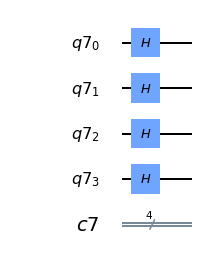

In [45]:
qr = QuantumRegister(4)
cr = ClassicalRegister(4)
program = QuantumCircuit(qr, cr)
program.h(qr)
program.draw(output='mpl')

### The oracle
How will the list items be provided to the quantum computer? A common way to encode such a list is in terms of a function f which returns f(x)=0 for all unmarked items x and f(w)=1 for the winner. To use a quantum computer for this problem, we must provide the items in superposition to this function, so we encode the function into a unitary matrix called an oracle. First we choose a binary encoding of the items x,w∈{0,1}n so that N=2n; now we can represent it in terms of qubits on a quantum computer. Then we define the oracle matrix Uf to act on any of the simple, standard basis states |x⟩ by Uf|x⟩=(−1)f(x)|x⟩.

We see that if x is an unmarked item, the oracle does nothing to the state. However, when we apply the oracle to the basis state |w⟩, it maps Uf|w⟩=−|w⟩. Geometrically, this unitary matrix corresponds to a reflection about the origin for the marked item in an N=2n dimensional vector space.

Mark states |1001⟩ using a phase oracle:
$$|ψ2⟩=\frac{1}{\sqrt{8}}–√(|0000⟩+|0001⟩+|0010⟩+|0011⟩+|0100⟩⟩+|0101⟩+|0110⟩+|0111⟩+|1000⟩-|1001⟩+|1010⟩+|1011⟩+|1100⟩⟩+|1101⟩+|1110⟩+|1111⟩)$$



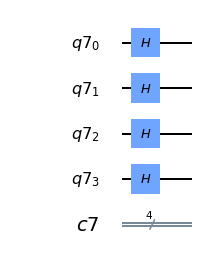

In [46]:
def oracle(secret):
    secretArr = np.asarray(secret)
    indices = np.where(secretArr == 0)[0] 
    for i in range(len(indices)):
        index = int(len(secretArr) - 1 - indices[i])
        program.x(qr[index])
    return secretArr

oracle(secret)
program.draw(output='mpl')

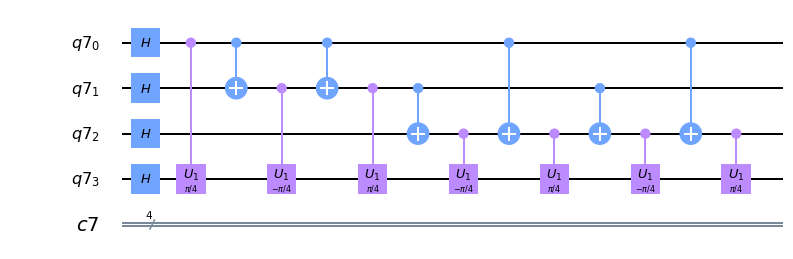

In [47]:
def cccZ():
    # Triple controlled Pauli Z-Gate (cccZ).
    program.cu1(np.pi / 4, qr[0], qr[3])
    program.cx(qr[0], qr[1])
    program.cu1(-np.pi / 4, qr[1], qr[3])
    program.cx(qr[0], qr[1])
    program.cu1(np.pi/4, qr[1], qr[3])
    program.cx(qr[1], qr[2])
    program.cu1(-np.pi/4, qr[2], qr[3])
    program.cx(qr[0], qr[2])
    program.cu1(np.pi/4, qr[2], qr[3])
    program.cx(qr[1], qr[2])
    program.cu1(-np.pi/4, qr[2], qr[3])
    program.cx(qr[0], qr[2])
    program.cu1(np.pi/4, qr[2], qr[3])

cccZ()
oracle(secret)
program.draw(output='mpl')

We have applied our first flip, which takes our register initially in state ∣0⟩ and marks one of its values, as shown in the equation above. We must now apply our mirror operation. Together, the flip and mirror subroutines are a powerful combination. flip allows us to target a value of the register and distinguish its phase from the others. mirror then converts this phase difference into a magnitude difference. We’ll refer to this combined operation, shown in Figure 6-5, as an amplitude amplification (AA) iteration.
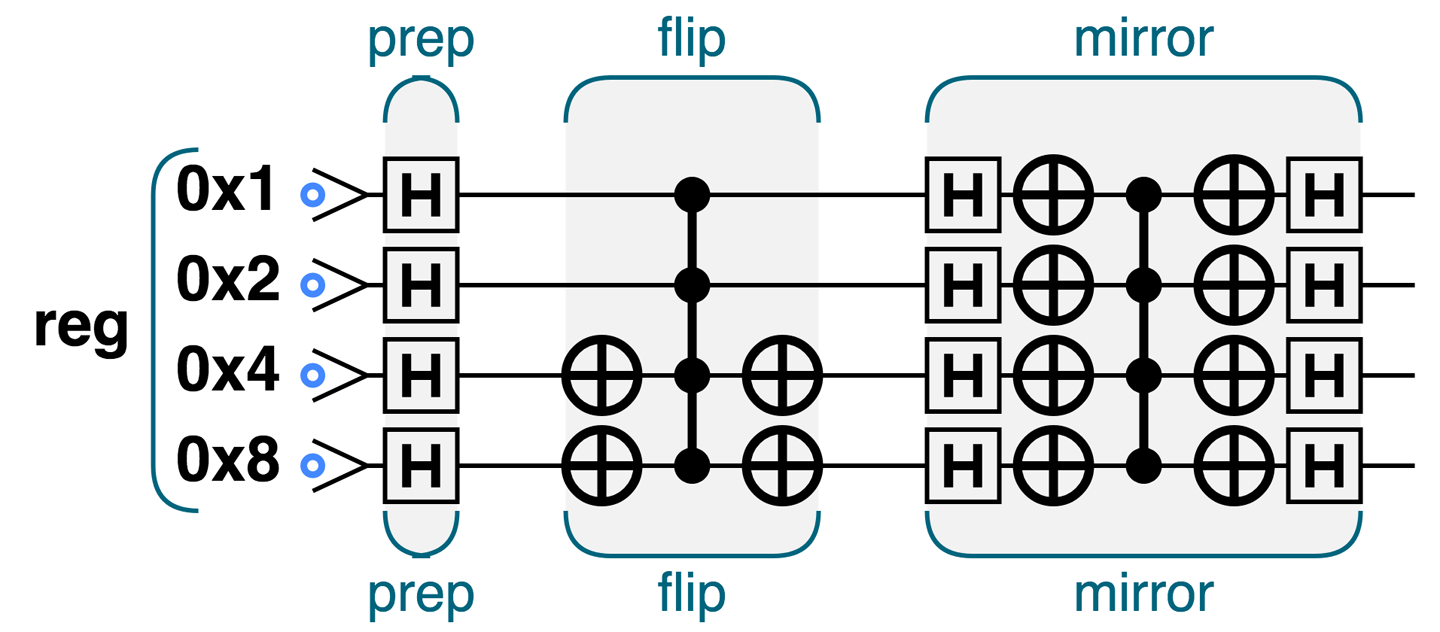

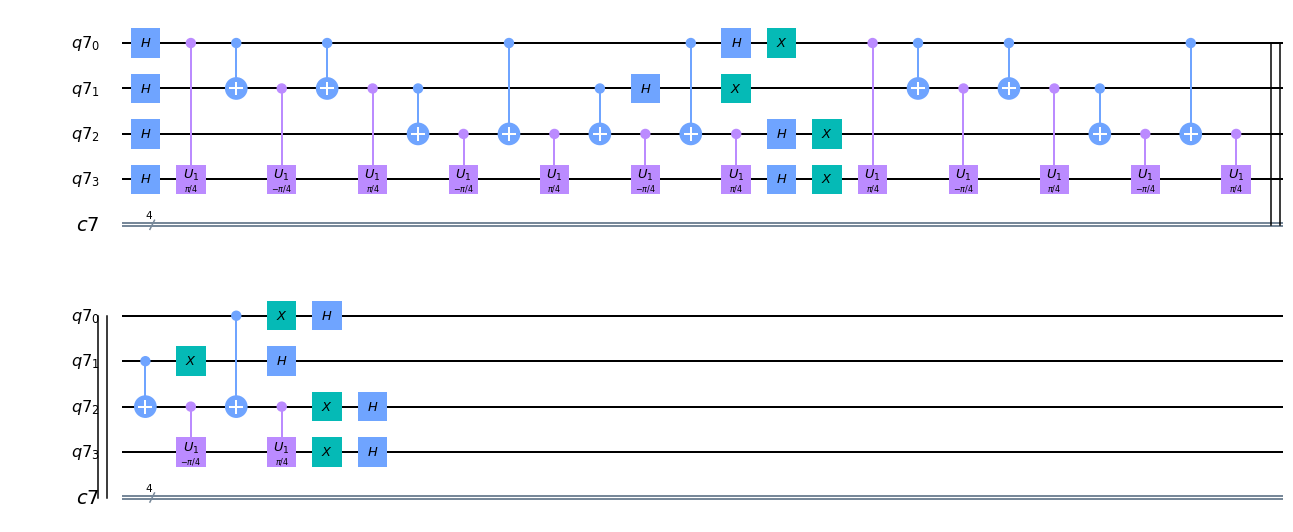

In [48]:
program.h(qr)
program.x(qr)
cccZ()
program.x(qr)
program.h(qr)
program.draw(output='mpl')

We can now measure our states, the magnitudes within each state are now very different, and performing a READ on the QPU register is very likely (though not certain) to reveal which value had its phase flipped, and hence which of the three states our register had been in. Instead of all values having the same probability of 6.25%, the marked value now has a READ probability of about 47.3%, with the nonmarked values being at about 3.5%. At this point, READing the register gives us an almost 50% chance of obtaining the value that had its phase flipped. That’s still not great.

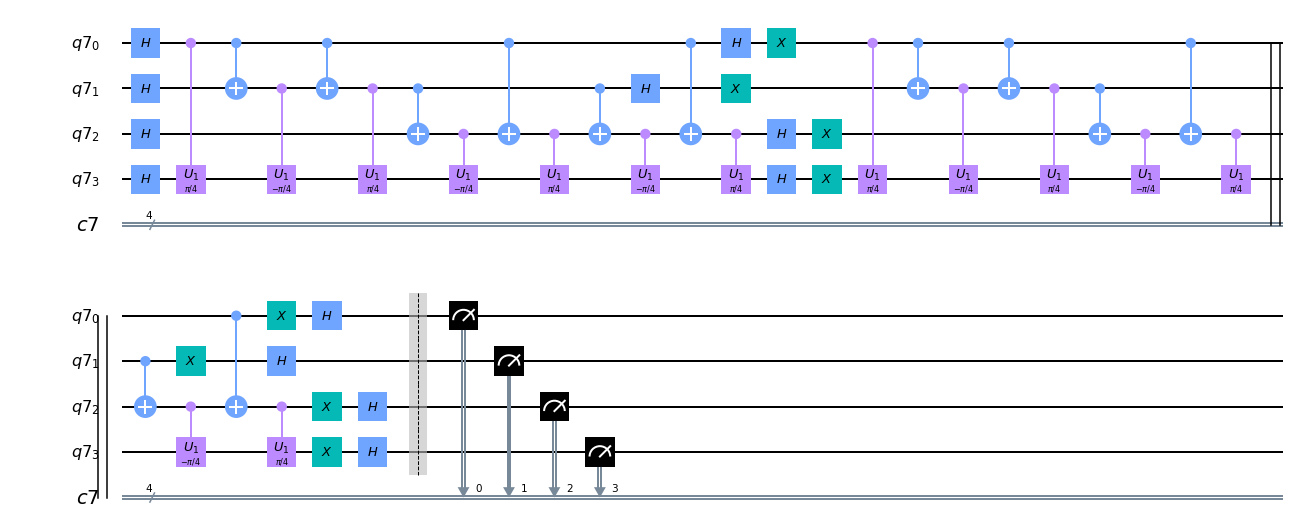

In [49]:
program.barrier(qr)
program.measure(qr, cr)
program.draw(output='mpl')

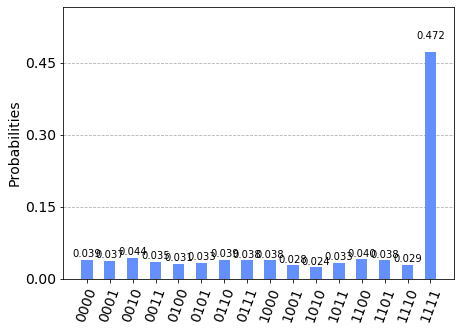

In [52]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(program, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

Can we repeat the operation again to try to further improve our probability of success? Applying the mirror subroutine again simply leaves us where we started, converting the magnitude differences back into differences of phase. However, suppose that before reapplying mirror we also reapply the flip subroutine (to re-flip the marked value). This starts us out with another phase difference before our second mirror application.

Following two applications of flip-mirror, the probability of finding our marked value has jumped from 47.3% to 90.8%!

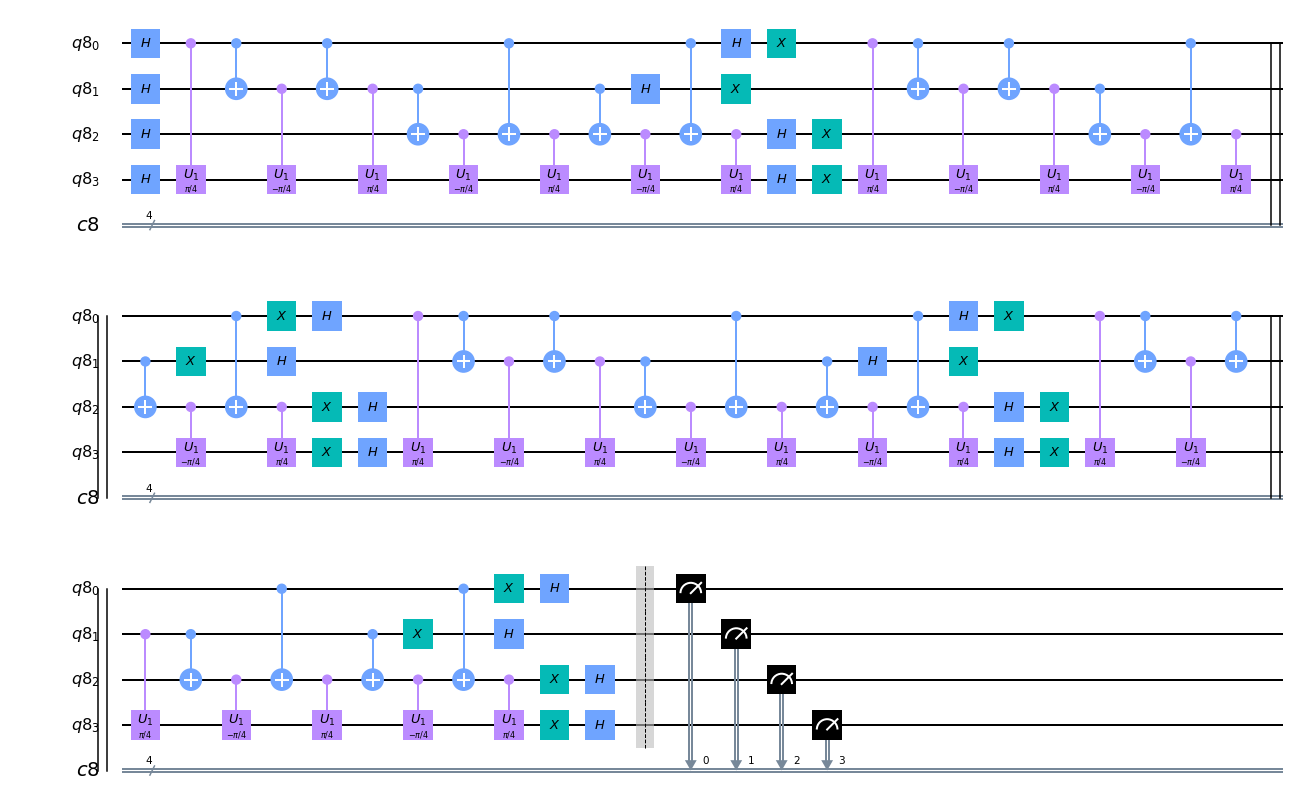

In [53]:
qr = QuantumRegister(4)
cr = ClassicalRegister(4)
program = QuantumCircuit(qr, cr)
program.h(qr)

def AA():
    oracle(secret)
    cccZ()
    oracle(secret)
    program.h(qr)
    program.x(qr)
    cccZ()
    program.x(qr)
    program.h(qr)
    
AA()
AA()
program.barrier(qr)
program.measure(qr, cr)
program.draw(output='mpl')

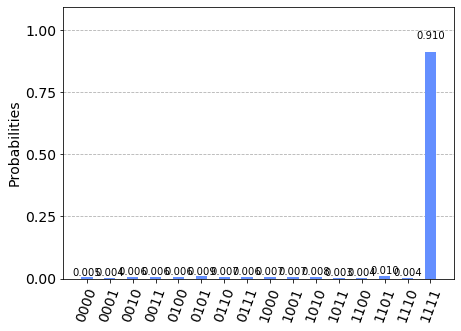

In [54]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(program, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

Through testing on a classical CPU, we can easily see that we have proven our result, by running 2 cylcs of amplitude amplification, we have almost doubled or chances of finding the correct result.

We will now try our newly improved quantum circuit on a real QPU, to see what happens when we run our experiment in the real quantum world.

In [63]:
backend = provider.get_backend(name='ibmq_ourense')
shots = 2048
job = execute(program, backend=backend, shots=shots)

job_monitor(job, interval = 2)

Job Status: job has successfully run


Please wait until the previous job has finished running before trying to plot the histogram.

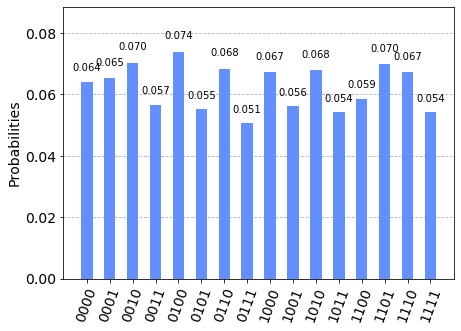

In [64]:
results = job.result()
answer = results.get_counts(program)
plot_histogram(answer)

As we can see, on a real QPU, there are many phenomena that contribute to the general "noise". Temperature is a main factor. Our results are very different from our CPU simulated ones. To counter this, is it possible to adapt the number of iterations of our AA cycle depending on the number of states we are looking for. The probabilities for a sort of "phase", alternating between 0 and 1.

Since Qiskit limits the number of gates a circuit can hold, we will not provide an implementation of this. The image below shows the probabilities of finding one marked value depending on the number of iterations of our flip + mirror
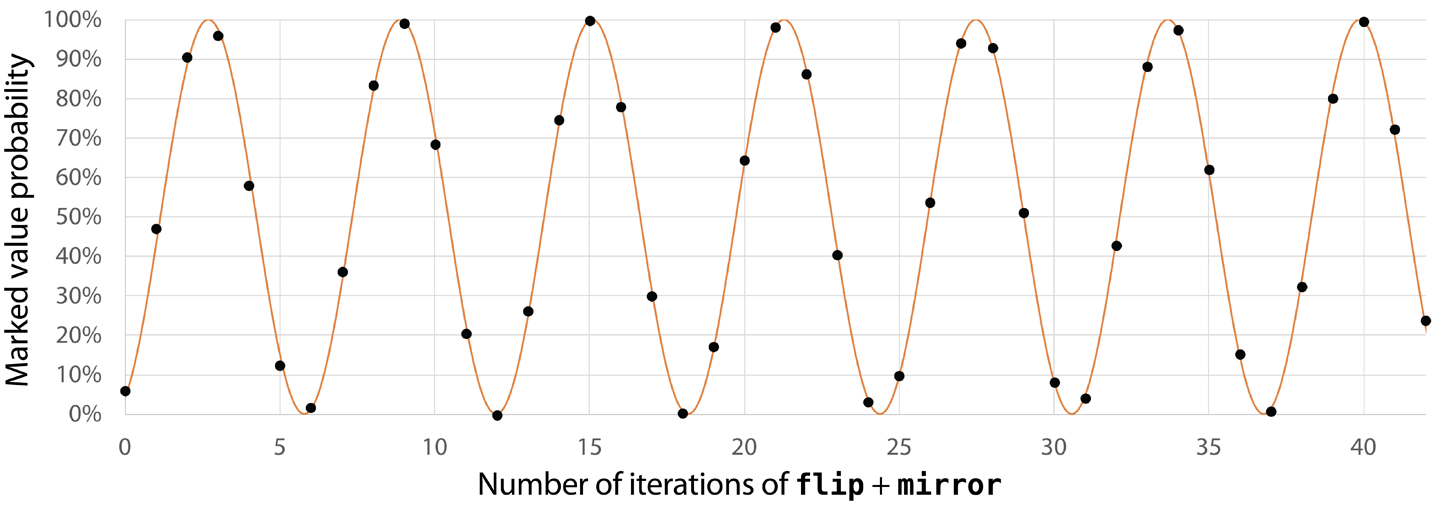